In [1]:
import uproot4
import awkward as ak
import vector

import numpy as np
import matplotlib.pyplot as plt

import particle
import hepunits

In [3]:
print(
    f'awkward version {ak.__version__}'
)

awkward version 1.7.0


In [6]:
data = uproot4.open('MuonEG_Run2015D_nanoAOD.root:aod2nanoaod')

In [7]:
data['Events'].show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
run                  | int32_t                  | AsDtype('>i4')
luminosityBlock      | uint32_t                 | AsDtype('>u4')
event                | uint64_t                 | AsDtype('>u8')
HLT_IsoMu24_eta2p1   | bool                     | AsDtype('bool')
HLT_IsoMu24          | bool                     | AsDtype('bool')
HLT_IsoMu17_eta2p... | bool                     | AsDtype('bool')
nMuon                | uint32_t                 | AsDtype('>u4')
Muon_pt              | float[]                  | AsJagged(AsDtype('>f4'))
Muon_eta             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_phi             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_mass            | float[]                  | AsJagged(AsDtype('>f4'))
Muon_charge          | int32_t[]                | AsJagged(AsDtype('>i4'))
Muon_

In [8]:
events = data['Events'].arrays(library="ak", how="zip")
ak.type(events)

10000 * {"run": int32, "luminosityBlock": uint32, "event": uint64, "HLT_IsoMu24_eta2p1": bool, "HLT_IsoMu24": bool, "HLT_IsoMu17_eta2p1_LooseIsoPFTau20": bool, "nMuon": uint32, "nElectron": uint32, "Muon": var * {"pt": float32, "eta": float32, "phi": float32, "mass": float32, "charge": int32, "pfRelIso03_all": float32, "pfRelIso04_all": float32, "tightId": bool, "softId": bool, "dxy": float32, "dxyErr": float32, "dz": float32, "dzErr": float32, "jetIdx": int32, "genPartIdx": int32}, "Electron": var * {"pt": float32, "eta": float32, "phi": float32, "mass": float32, "charge": int32, "pfRelIso03_all": float32, "dxy": float32, "dxyErr": float32, "dz": float32, "dzErr": float32, "cutBasedId": bool, "pfId": bool, "jetIdx": int32, "genPartIdx": int32}}

Text(0.5, 0, '# muons')

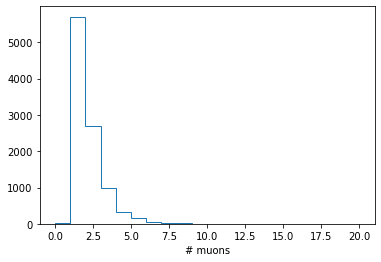

In [9]:
n,b,_ = plt.hist(events.nMuon, histtype='step', bins=20, range=(0,20))
plt.xlabel('# muons')

Text(0.5, 0, '# electrons')

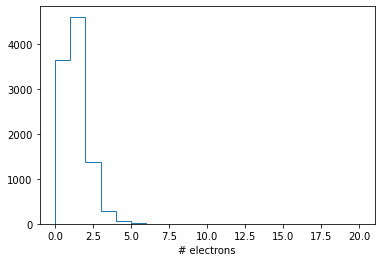

In [10]:
n,b,_ = plt.hist(events.nElectron, histtype='step', bins=20, range=(0,20))
plt.xlabel('# electrons')

In [11]:
events['Muon', 'ip3d'] = np.sqrt(
    events.Muon.dxy*events.Muon.dxy + 
    events.Muon.dz*events.Muon.dz
)

events['Electron', 'ip3d'] = np.sqrt(
    events.Electron.dxy*events.Electron.dxy +
    events.Electron.dz*events.Electron.dz
)

events['Muon', 'sip3d'] = np.sqrt(
    events.Muon.dxyErr*events.Muon.dxyErr +
    events.Muon.dzErr*events.Muon.dzErr
)

events['Electron', 'sip3d'] = np.sqrt(
    events.Electron.dxyErr*events.Electron.dxyErr +
    events.Electron.dzErr*events.Electron.dzErr
)

events['Muon', 'sip3d'] = events.Muon.ip3d / events.Muon.sip3d
events['Electron', 'sip3d'] = events.Electron.ip3d / events.Electron.sip3d

In [12]:
fourMuons = events[
    (events.nMuon >= 4) &
    ak.all(events.Muon.pt > 5, axis=1) &
    ak.all(abs(events.Muon.eta) < 2.4, axis=1) &
    ak.all(events.Muon.dxy < 0.5, axis=1) &
    ak.all(events.Muon.dz < 1.0, axis=1) &
    ak.all(events.Muon.sip3d < 4, axis=1) 
]

fourElectrons = events[
    (events.nElectron >= 4) & 
    ak.all(events.Electron.pt > 7, axis=1) &
    ak.all(abs(events.Electron.eta) < 2.5, axis=1) &
    ak.all(events.Electron.dxy < 0.5, axis=1) &
    ak.all(events.Electron.dz < 1.0, axis=1) &
    ak.all(events.Electron.sip3d < 4, axis=1) 
]

twoMuonsTwoElectrons = events[
    (events.nElectron > 1) & (events.nMuon > 1) 
]

twoMuonsTwoElectrons = twoMuonsTwoElectrons[
    ak.all(twoMuonsTwoElectrons.Electron.pt > 7, axis=1) & 
    ak.all(twoMuonsTwoElectrons.Muon.pt > 5, axis=1) &
    ak.all(abs(twoMuonsTwoElectrons.Electron.eta) < 2.5, axis=1) & 
    ak.all(abs(twoMuonsTwoElectrons.Muon.eta) < 2.4, axis=1) 
]

In [13]:
fourMuons = fourMuons[
    fourMuons.nMuon == 4
]

fourElectrons = fourElectrons[
    fourElectrons.nElectron == 4
]

twoMuonsTwoElectrons = twoMuonsTwoElectrons[
    (twoMuonsTwoElectrons.nMuon == 2) &
    (twoMuonsTwoElectrons.nElectron == 2)
]

In [14]:
fourMuons = fourMuons[
    ak.sum(fourMuons.Muon.charge, axis=1) == 0
]

fourElectrons = fourElectrons[
    ak.sum(fourElectrons.Electron.charge, axis=1) == 0
]

twoMuonsTwoElectrons = twoMuonsTwoElectrons[
    (ak.sum(twoMuonsTwoElectrons.Muon.charge, axis=1) == 0) &
    (ak.sum(twoMuonsTwoElectrons.Electron.charge, axis=1) == 0)
]

In [15]:
len(fourMuons), len(fourElectrons), len(twoMuonsTwoElectrons)

(7, 3, 29)

**TO-DO**: all leptons are required to have a relative isolation < 0.35 and to satisfy tight ID requirements

In [16]:
print(
    [pt for pt in fourElectrons.Electron.pt]
)

[<Array [16.1, 61.5, 13.6, 13.5] type='4 * float32'>, <Array [16.3, 8.91, 8.4, 39] type='4 * float32'>, <Array [8.62, 12.9, 25.1, 49.6] type='4 * float32'>]


It doesn't seem (as it should?) that the muons and electrons are sorted by pt. Perhaps something got lost in the filtering and/or conversion to array.

In [17]:
print(
    [ak.count_nonzero(e) > 1 for e in fourElectrons.Electron.pt > 10]
)

[True, True, True]


In [18]:
fourMuons = fourMuons[
    ak.any(fourMuons.Muon.pt > 20, axis=1)
]

fourElectrons = fourElectrons[
    ak.any(fourElectrons.Electron.pt > 20, axis=1)
]

twoMuonsTwoElectrons = twoMuonsTwoElectrons[
    ak.any(twoMuonsTwoElectrons.Electron.pt > 20, axis=1) |
    ak.any(twoMuonsTwoElectrons.Muon.pt > 20, axis=1)
]

In [19]:
fourMuons = fourMuons[
    [ak.count_nonzero(e) > 1 for e in fourMuons.Muon.pt > 10]
]

fourElectrons = fourElectrons[
    [ak.count_nonzero(e) > 1 for e in fourElectrons.Electron.pt > 10]
]

In [20]:
len(fourMuons), len(fourElectrons), len(twoMuonsTwoElectrons)

(5, 3, 23)

**TO-DO**: leptons are required to be separated by $\Delta R(l_{1}, l_{2}) > 0.02$ and muons and electrons are required to be separated by $\Delta R(e, \mu) > 0.05$

**TO-DO**: $m_{l_{1}l_{2}} >$ 4 GeV

From the analysis note AN2016_029_v11:

"Z candidates are build using two oppositely charged leptons of the same flavor. Each pair
is retained if it satisfies 4 < $m_{Z}$ < 120 GeV. All possible four-lepton candidates in an event
are then considered. Within each candidate, the dilepton pair with invariant mass closest to
nominal $m_{Z}$ is designated $Z_{1}$, the other $Z_{2}$. The event is kept if 40 < $m_{Z1}$ < 120 GeV, 4 < $m_{Z2}$ < 120GeV."

In [21]:
vector.register_awkward()

four_vectors = ak.Array(
    {
        "pt": fourElectrons.Electron.pt,
        "eta": fourElectrons.Electron.eta,
        "phi": fourElectrons.Electron.phi,
        "mass": fourElectrons.Electron.mass,
        "charge": fourElectrons.Electron.charge
    }, with_name="Momentum4D"
)

In [22]:
four_vectors

<MomentumArray4D [{pt: [16.1, 61.5, 13.6, ... -1, -1]}] type='3 * Momentum4D["pt...'>

**NOTE**: The above MomentumArray4D is the "proper" way to handle invariant mass and deltaR but need to think about how best to use. For now, use the "old way".

In [24]:
electrons = ak.zip({
    "pt": fourElectrons.Electron.pt,
    "eta": fourElectrons.Electron.eta,
    "phi": fourElectrons.Electron.phi,
    "mass": fourElectrons.Electron.mass,
    "charge": fourElectrons.Electron.charge
})

muons = ak.zip({
    "pt": fourMuons.Muon.pt,
    "eta": fourMuons.Muon.eta,
    "phi": fourMuons.Muon.phi,
    "mass": fourMuons.Muon.mass,
    "charge": fourMuons.Muon.charge
})

In [25]:
electron_pairs = ak.combinations(electrons, 2)
e1, e2 = ak.unzip(electron_pairs)

muon_pairs = ak.combinations(muons, 2)
mu1, mu2 = ak.unzip(muon_pairs)

In [26]:
ee_mass = np.sqrt(2*e1.pt*e2.pt*(np.cosh(e1.eta - e2.eta) - np.cos(e1.phi - e2.phi)))
mumu_mass = np.sqrt(2*mu1.pt*mu2.pt*(np.cosh(mu1.eta - mu2.eta) - np.cos(mu1.phi - mu2.phi)))

In [27]:
ee_mass = ee_mass[e1.charge != e2.charge]
mumu_mass = mumu_mass[mu1.charge != mu2.charge]

In [28]:
mZ = particle.Particle.findall("Z0")[0].mass / hepunits.GeV

closest_to_mZ = ak.argmin(abs(ee_mass - mZ), axis=1, keepdims=True)

masses = ak.ravel(ee_mass[closest_to_mZ])

print(
    masses
)

closest_to_mZ = ak.argmin(abs(mumu_mass - mZ), axis=1, keepdims=True)

masses = np.append(masses, ak.ravel(mumu_mass[closest_to_mZ]))

[82.6, 61.2, 51.4]


Text(0.5, 0, 'mZ1 [GeV]')

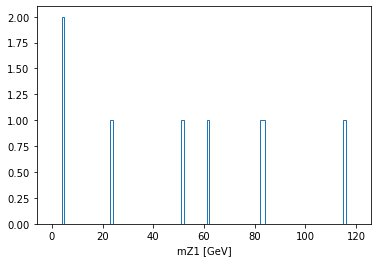

In [29]:
n,b,_ = plt.hist(
    masses, 
    histtype='step', 
    bins=120, range=(0,120)
)

plt.xlabel('mZ1 [GeV]')

**TO-DO**: handle 2e2mu 